In [1]:
import torch
import torchvision
from torchvision import models #  import pretrained model from torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 400
batch_size = 64

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
# define the pretrained model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# net = models.alexnet(pretrained=True)
net=models.resnet18(pretrained=True)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [5]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# freeze all the layers except for the final classifier

for param in net.parameters():
    param.requires_grad = False
net = net.to(device)

# change the final classifier into binary classifier by overwriting the number of the final features
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2).to(device) # change the no. of out_features from 1000 to 2

In [7]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# In the case where you need to change the training rate, use scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [9]:
# data_dir='../../../data_single/'
# data_dir='../../../data_indiv/'  #after fixed
data_dir='../../../data_indiv_original/' 
# data_dir = '../../hymenoptera_data/hymenoptera_data/'

train_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader=torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
# TRAIN THE NETWORK


num_epochs = 20

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr:{learning_rate}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, 
                   learning_rate=optimizer.param_groups[0]['lr']))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

Epoch [1/20], Loss: 0.0135, val_loss: 0.0133, val_acc: 0.6268, lr:0.01
Epoch [2/20], Loss: 0.0096, val_loss: 0.0471, val_acc: 0.4366, lr:0.01
Epoch [3/20], Loss: 0.0090, val_loss: 0.0251, val_acc: 0.4930, lr:0.01


In [ ]:
# data original 359
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'royalblue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'darkorange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0,0.05])
# plt.xlim([0,20])

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'royalblue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'darkorange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.5,1])
# plt.xlim([0,20])

(0.5, 1.0)

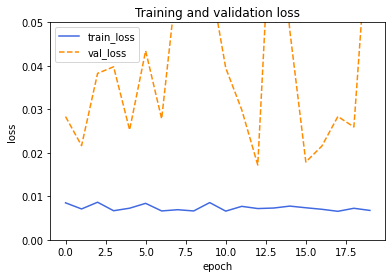

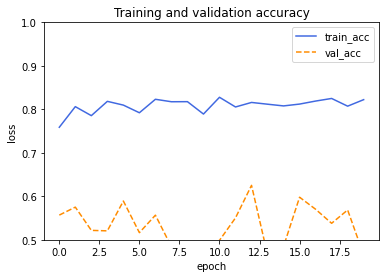

In [11]:
# after fixed
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'royalblue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'darkorange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0,0.05])
# plt.xlim([0,20])

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'royalblue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'darkorange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.5,1])
# plt.xlim([0,20])

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

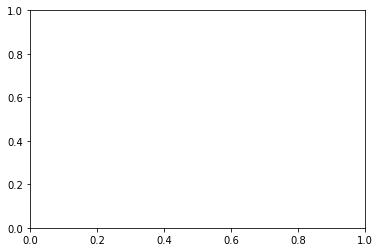

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'royalblue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'darkorange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0,0.05])
# plt.xlim([0,20])

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'royalblue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'darkorange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.5,1])
# plt.xlim([0,20])